### 1. Data Preprocessing & Exploration

In [59]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

try:
    df = pd.read_csv('../datasets/insurance_us.csv')
    display(df.sample(5))
except:
    print("Data not found")

,Gender,Age,Salary,Family members,Insurance benefits
3858,1,36.0,38600.0,1,0
2359,1,23.0,32100.0,1,0
1070,0,28.0,42300.0,0,0
2758,0,22.0,24500.0,0,0
950,0,36.0,30300.0,0,0


We rename the columns to make the code look more consistent with its style.

In [60]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [61]:
df.sample(5)

,gender,age,income,family_members,insurance_benefits
4757,1,43.0,52900.0,2,1
3950,1,33.0,39400.0,0,0
3411,1,25.0,49000.0,2,0
2520,1,21.0,46100.0,2,0
944,0,50.0,37900.0,0,2


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


We want to change the data type of age to integer.

In [63]:
try:
    df['age'] = df['age'].astype('int')
    display(df.info())
except:
    print("data conversion unsuccessful")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int32  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 175.9 KB


None

We now check for duplicate entries.

In [64]:
display(df[df.duplicated() == True].count())

gender                153
age                   153
income                153
family_members        153
insurance_benefits    153
dtype: int64

In [65]:
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True) 
entries = df.shape[0]
print("After duplicate removal there are now {} entries".format(entries))

After duplicate removal there are now 4847 entries


Now checking for nulls.

In [66]:
df.isna().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

Now all of the data is ready for analysis.

In [67]:
df.iloc[3920]

gender                    1.0
age                      19.0
income                45900.0
family_members            0.0
insurance_benefits        0.0
Name: 3920, dtype: float64

### 2. EDA

Let's quickly check whether there are apparent groups of customers by looking at the pair plot.

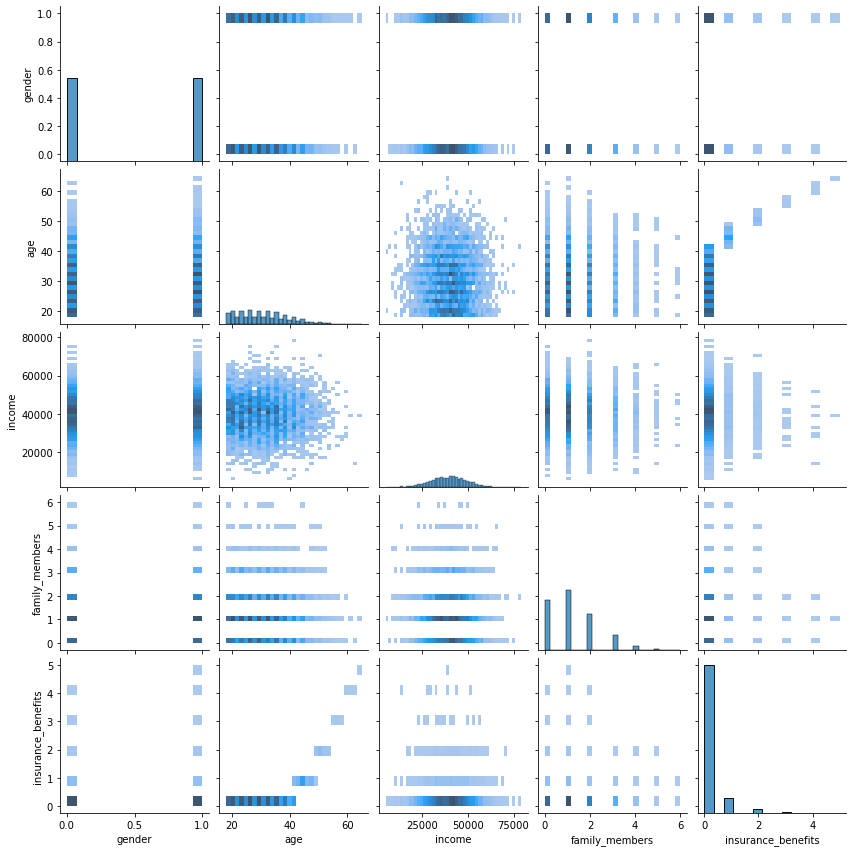

In [68]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

It is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where linear algebra and machine learning can be quite handy.

### 3. Tasks
#### 3.1  Similar Customers

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [69]:
feature_names = ['gender', 'age', 'income', 'family_members']
target = 'insurance_benefits'

In [70]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric, algorithm='brute').fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    return df_res

Scaling the data.

In [71]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [72]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
411,1.0,0.461538,0.544304,0.000000,0
819,0.0,0.338462,0.368354,0.333333,0
3621,0.0,0.830769,0.415190,0.333333,2
4168,0.0,0.338462,0.316456,0.500000,0
577,0.0,0.323077,0.381013,0.166667,0


Now, let's get similar records for a given one for every combination

In [73]:
# not scaled, Euclidean
warnings.filterwarnings("ignore")
get_knn(df,1,5,'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
1,0,46,38000.0,1,1,0.000000
3810,0,40,38000.0,0,0,6.082763
4796,1,37,38000.0,1,0,9.055385
2480,1,36,38000.0,0,0,10.099505
3498,0,33,38000.0,0,0,13.038405


In [74]:
# scaled, Euclidean
get_knn(df_scaled,1,5,'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
1,0.0,0.707692,0.481013,0.166667,1,0.000000
4041,0.0,0.707692,0.477215,0.166667,1,0.003797
1835,0.0,0.707692,0.492405,0.166667,1,0.011392
4833,0.0,0.723077,0.491139,0.166667,1,0.018418
4341,0.0,0.692308,0.459494,0.166667,1,0.026453


In [75]:
# not scaled, Manhattan
get_knn(df,1,5,'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
1,0,46,38000.0,1,1,0.0
3810,0,40,38000.0,0,0,7.0
4796,1,37,38000.0,1,0,10.0
2480,1,36,38000.0,0,0,12.0
3498,0,33,38000.0,0,0,14.0


In [76]:
# scaled, Manhattan
get_knn(df_scaled,1,5,'manhattan')

,gender,age,income,family_members,insurance_benefits,distance
1,0.0,0.707692,0.481013,0.166667,1,0.000000
4041,0.0,0.707692,0.477215,0.166667,1,0.003797
1835,0.0,0.707692,0.492405,0.166667,1,0.011392
4833,0.0,0.723077,0.491139,0.166667,1,0.025511
2394,0.0,0.676923,0.482278,0.166667,1,0.032035


**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

The data being scaled affects the kNN algorithm. It can be seen in the difference between the resulting neighbours using Euclidean or Manhattan metric. The kNN finds neighbours with the same income using unscaled data, due to the larger magnitude of the feature, while finding neighbours with the same gender or family members when scaled. 

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results are largely similar between Euclidean and Manhattan metric, regardless of scaling.

#### 3.2 Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [77]:
# calculate the target

df['insurance_benefits_received'] = np.where(df['insurance_benefits'] > 0, 1, 0)

In [78]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

In [79]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    DetaFrame_cm = pd.DataFrame(cm, range(2), range(2))
    sns.heatmap(DetaFrame_cm, annot=True,cbar=False,square=True,cmap='inferno')
    plt.title('Confusion matrix')
    plt.tight_layout()
    plt.show()

In [80]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

Probability: 0.00
F1: 0.00


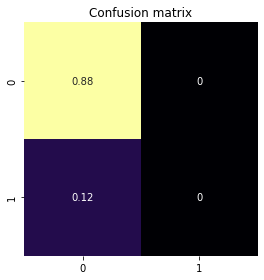

Probability: 0.12
F1: 0.13


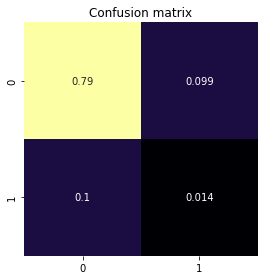

Probability: 0.50
F1: 0.19


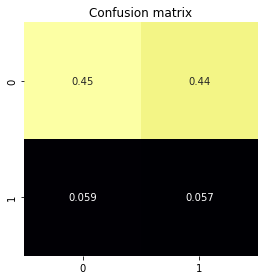

Probability: 1.00
F1: 0.21


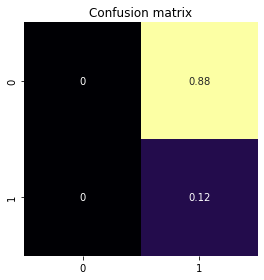

In [81]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'Probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P,len(df),42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)

Scores using 1 neighbours:
F1: 0.67


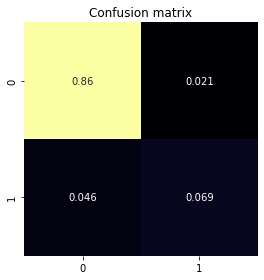

Scores using 2 neighbours:
F1: 0.38


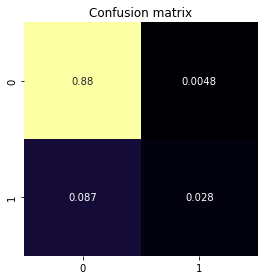

Scores using 3 neighbours:
F1: 0.38


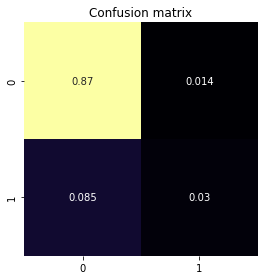

Scores using 4 neighbours:
F1: 0.18


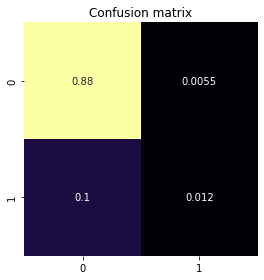

Scores using 5 neighbours:
F1: 0.23


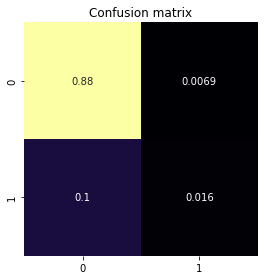

Scores using 6 neighbours:
F1: 0.06


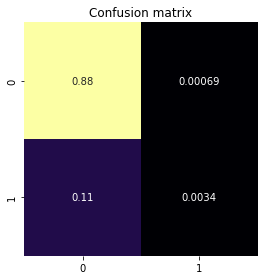

Scores using 7 neighbours:
F1: 0.07


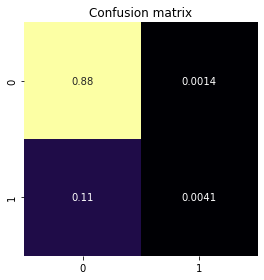

Scores using 8 neighbours:
F1: 0.00


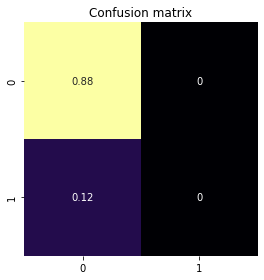

Scores using 9 neighbours:
F1: 0.01


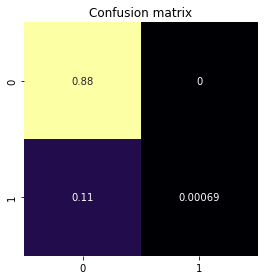

Scores using 10 neighbours:
F1: 0.00


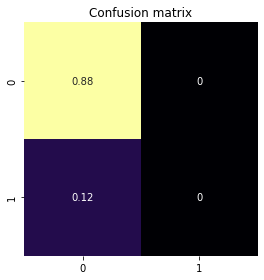

In [82]:
# using unscaled data
target = 'insurance_benefits_received'
feature_names = ['gender', 'age', 'income', 'family_members']

df_train, df_valid = train_test_split(df, test_size=0.3,random_state=12345)

def test_n_neighbours(df_train,df_valid):
    for n in range(1,11):
        nbrc = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n)
        nbrc.fit(df_train[feature_names], df_train[target])
        y_pred = nbrc.predict(df_valid[feature_names])
        print("Scores using {} neighbours:".format(n))
        eval_classifier(df_valid['insurance_benefits_received'], y_pred)

test_n_neighbours(df_train,df_valid)

We can see the F1 scores of the unscaled data performing better with few neighbours but worse as the number of neighbours increases.

Scores using 1 neighbours:
F1: 0.93


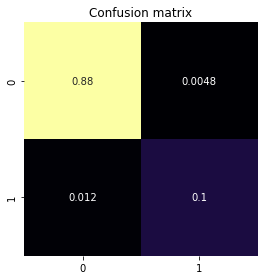

Scores using 2 neighbours:
F1: 0.89


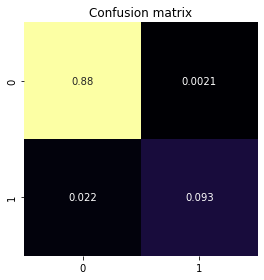

Scores using 3 neighbours:
F1: 0.91


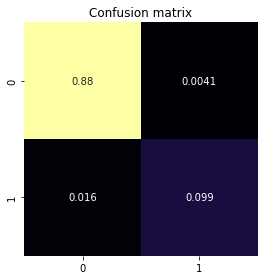

Scores using 4 neighbours:
F1: 0.88


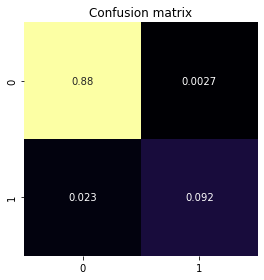

Scores using 5 neighbours:
F1: 0.89


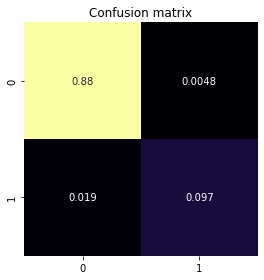

Scores using 6 neighbours:
F1: 0.87


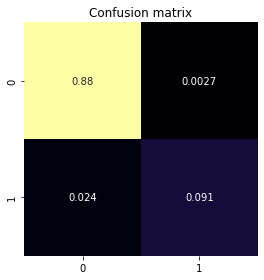

Scores using 7 neighbours:
F1: 0.90


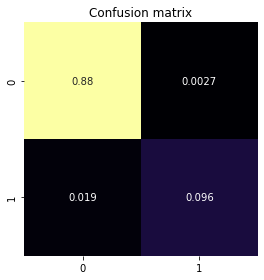

Scores using 8 neighbours:
F1: 0.86


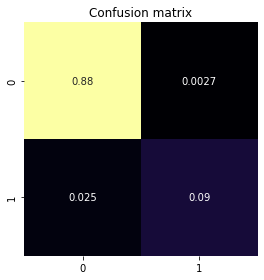

Scores using 9 neighbours:
F1: 0.87


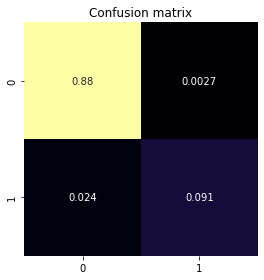

Scores using 10 neighbours:
F1: 0.86


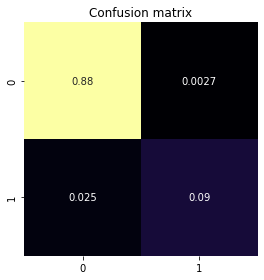

In [83]:
# using scaled data
df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

df_train, df_valid = train_test_split(df_scaled, test_size=0.3,random_state=12345)

test_n_neighbours(df_train,df_valid)

The kNN classification approach performed far better with the scaled data, with a drop-off in accuracy as the number of neighbours increased.

#### 3.3 Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [84]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    def predict(self, X):
        
        y_pred = X.dot(self.weights)
        
        return y_pred

In [85]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

Now we evaluate the model without scaling:

In [86]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 2.28587827e-02 -3.57052853e-02 -1.13606227e-05 -4.73354538e-02]
RMSE: 0.39
R2: 0.57


Now we evaluate the model with scaled data:

In [87]:
# using scaled data
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 1.48582087 -0.03570529 -0.89748919 -0.28401272]
RMSE: 0.39
R2: 0.57


We can see that the linear regression model is fairly accurate by the RMSE and R2 scores, and isn't affected by scaled data (the weights are different but the end result is just as accurate).

#### 3.4 Obfuscating Data

In [88]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [89]:
X = df_pn.to_numpy()
print(X)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]


Generating a random matrix $P$.

In [90]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
print(P)

[[0.77395605 0.43887844 0.85859792 0.69736803]
 [0.09417735 0.97562235 0.7611397  0.78606431]
 [0.12811363 0.45038594 0.37079802 0.92676499]
 [0.64386512 0.82276161 0.4434142  0.22723872]]


Checking the matrix $P$ is invertible

In [91]:
try:
    np.linalg.inv(P)
    print("P is invertible")
except:
    print("P is not invertible")

P is invertible


Can you guess the customers' ages or income after the transformation?

In [92]:
transformed_X = X @ P
print(transformed_X)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [93]:
reversed_X = transformed_X @ np.linalg.inv(P)
print(reversed_X)

[[1.00000000e+00 4.10000000e+01 4.96000000e+04 1.00000000e+00]
 [6.66555413e-13 4.60000000e+01 3.80000000e+04 1.00000000e+00]
 [3.84747671e-13 2.90000000e+01 2.10000000e+04 1.41940791e-12]
 ...
 [1.18077361e-12 2.00000000e+01 3.39000000e+04 2.00000000e+00]
 [1.00000000e+00 2.20000000e+01 3.27000000e+04 3.00000000e+00]
 [1.00000000e+00 2.80000000e+01 4.06000000e+04 1.00000000e+00]]


Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [94]:
rng = np.random.default_rng(12345)
customers =  rng.integers(low=0, high=len(df), size=5)
print(customers)

[3389 1101 3822 1535  989]


In [95]:
# original
X[customers]

array([[1.00e+00, 2.60e+01, 3.58e+04, 0.00e+00],
       [1.00e+00, 3.60e+01, 3.34e+04, 0.00e+00],
       [1.00e+00, 2.70e+01, 3.00e+04, 1.00e+00],
       [1.00e+00, 4.20e+01, 4.05e+04, 0.00e+00],
       [1.00e+00, 3.10e+01, 2.58e+04, 1.00e+00]])

In [96]:
# transformed
transformed_X[customers]

array([[ 4589.69061688, 16149.62163624, 13295.2174977 , 33199.32164075],
       [ 4283.15967194, 15078.45160881, 12412.91363656, 30982.94631056],
       [ 3847.36958983, 13539.18158041, 11145.79351105, 27825.09800845],
       [ 5193.33152802, 18282.04550198, 15050.14644682, 37567.69411722],
       [ 3309.66904198, 11651.46313066,  9591.48636808, 23935.82931251]])

In [97]:
#reversed
reversed_X[customers]

array([[1.00000000e+00, 2.60000000e+01, 3.58000000e+04, 3.65435738e-13],
       [1.00000000e+00, 3.60000000e+01, 3.34000000e+04, 5.38386600e-12],
       [1.00000000e+00, 2.70000000e+01, 3.00000000e+04, 1.00000000e+00],
       [1.00000000e+00, 4.20000000e+01, 4.05000000e+04, 3.36637152e-12],
       [1.00000000e+00, 3.10000000e+01, 2.58000000e+04, 1.00000000e+00]])

You can probably see that some values are not exactly the same as they are in the original data. 

**What might be the reason for that?**

The values are slightly off from a rounding error with floats.

#### Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

**Answer**

$w$ and $w_P$ are linked by multiplication of the $P$ matrix (by its original form or inverse) to result in identical y predictions.

**Analytical proof**

$X'=XP$

$w = (X^T X)^{-1} X^T y$

$w' = (X'^T X')^{-1} X'^T y $

$ = [(XP)^{T}(XP)]^{-1}(XP)^{T}y $

$= (P^{T}X^{T}XP)^{-1}P^{T}X^{T}y $

$ = (XP)^{-1}(P^T X^T)^{-1} (P^T X^T) y $

$=P^{-1}(X^{T}X)^{-1}P^{T^{-1}}P^{T}X^{T}y = P^{-1}w$  

Let $R = (P^T)^{-1}P^T$

$\hat{y}'= XPw' = XPP^{-1}w = XRw = Xw = \hat{y}$

#### Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use $XP$ as the new feature matrix

In [98]:
rng = np.random.default_rng(seed=42)
invertible = False
while invertible == False:
    P = rng.random(size=(X.shape[1], X.shape[1]))
    try:
        np.linalg.inv(P)
        invertible = True
    except:
        print("P isn't invertible")

print(P)

def evaluate(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
    lr = MyLinearRegression()
    lr.fit(X_train, y_train)
    y_test_pred = lr.predict(X_test)
    eval_regressor(y_test, y_test_pred)
        
def eval_obf(X,y,P):
    obf_X = X @ P
    evaluate(obf_X,y)

[[0.77395605 0.43887844 0.85859792 0.69736803]
 [0.09417735 0.97562235 0.7611397  0.78606431]
 [0.12811363 0.45038594 0.37079802 0.92676499]
 [0.64386512 0.82276161 0.4434142  0.22723872]]


In [99]:
evaluate(X,y)

RMSE: 0.39
R2: 0.57


In [100]:
eval_obf(X,y,P)

RMSE: 0.39
R2: 0.57


There is no difference between the RMSE and $R^2$ metric values for the linear regression on the original and obfuscated data.

### Conclusions

In the first part we looked at kNN algorithms and how it is affected by metrics and scaling, with the later having effect. In the second part we took a classification approach and boosted scores significantly with scaling. Then we performed a linear regression, saw its results and scores untouched by data scaling and obfuscation. We have seen the power of matrix operations to improve parts of models and procedures in data analysis.